In [2]:
import numpy as np
import gym
from dezero import Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L

/Users/nishiokakentaro/Desktop/py-playground/cartpole/.venv/lib/python3.9/site-packages/dezero/transforms.py:154: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def __init__(self, dtype=np.int):


In [6]:
class PolicyNet(Model):
    def __init__(self, action_size=2):
        super().__init__()
        self.l1 = L.Linear(128)
        self.l2 = L.Linear(action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        x = F.softmax(x)
        return x

class ValueNet(Model):
    def __init__(self):
        super().__init__()
        self.l1 = L.Linear(128)
        self.l2 = L.Linear(1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [4]:
class Agent:
    def __init__(self):
        self.gamma = 0.98
        self.lr_pi = 0.0002
        self.lr_v = 0.0005
        self.action_size = 2

        self.pi = PolicyNet()
        self.v = ValueNet()
        self.optimizer_pi = optimizers.Adam(self.lr_pi).setup(self.pi)
        self.optimizer_v = optimizers.Adam(self.lr_v).setup(self.v)

    def get_action(self, state):
        state = state[np.newaxis, :]
        probs = self.pi(state)
        probs = probs[0]
        action = np.random.choice(len(probs), p=probs.data)
        return action, probs[action]

    def update(self, state, action_prob, reward, next_state, done):
        state = state[np.newaxis, :]
        next_state = next_state[np.newaxis, :]

        # self.v
        target = reward + self.gamma * self.v(next_state) * (1 - done)
        target.unchain()
        v = self.v(state)
        loss_v = F.mean_squared_error(v, target)

        # self.pi
        delta = target - v
        delta.unchain()
        loss_pi = -F.log(action_prob) * delta

        self.v.cleargrads()
        self.pi.cleargrads()
        loss_v.backward()
        loss_pi.backward()
        self.optimizer_v.update()
        self.optimizer_pi.update()

In [8]:
episodes = 3000
env = gym.make('CartPole-v0')
agent = Agent()
reward_history = []

for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, prob = agent.get_action(state)
        next_state, reward, done, info = env.step(action)

        agent.update(state, prob, reward, next_state, done)
        state = next_state
        total_reward += reward

    reward_history.append(total_reward)

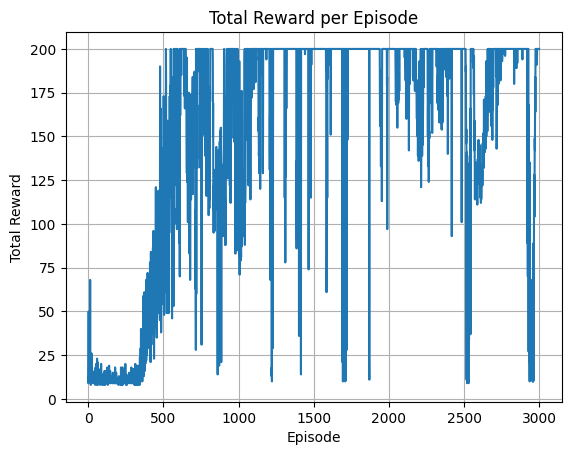

In [9]:
import matplotlib.pyplot as plt

plt.plot(reward_history)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()